In [1]:
!pip install /kaggle/input/rdkit-2025-3-3/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl

Processing /kaggle/input/rdkit-2025-3-3/rdkit-2025.3.3-cp311-cp311-manylinux_2_28_x86_64.whl


In [2]:
!pip install transformers rdkit pandas tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import polars as pl
from transformers import AutoTokenizer, AutoModel
import gc
import pickle
import torch
from tqdm import tqdm


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

import lightgbm as lgb

from sklearn.model_selection import KFold

import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops

In [4]:
class CFG:
    TARGETS = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    SEED = 100
    FOLDS = 5
    PATH = '/kaggle/input/neurips-open-polymer-prediction-2025/'

train = pd.read_csv(CFG.PATH + 'train.csv')
test = pd.read_csv(CFG.PATH + 'test.csv')

def make_smile_canonical(smile): # To avoid duplicates, for example: canonical '*C=C(*)C' == '*C(=C*)C'
    try:
        mol = Chem.MolFromSmiles(smile)
        canon_smile = Chem.MolToSmiles(mol, canonical=True)
        return canon_smile
    except:
        return np.nan

train['SMILES'] = train['SMILES'].apply(lambda s: make_smile_canonical(s))
test['SMILES'] = test['SMILES'].apply(lambda s: make_smile_canonical(s))

In [5]:
# https://www.kaggle.com/datasets/minatoyukinaxlisa/tc-smiles
data_tc = pd.read_csv('/kaggle/input/tc-smiles/Tc_SMILES.csv')
data_tc = data_tc.rename(columns={'TC_mean': 'Tc'})

# https://springernature.figshare.com/articles/dataset/dataset_with_glass_transition_temperature/24219958?file=42507037
data_tg2 = pd.read_csv('/kaggle/input/smiles-extra-data/JCIM_sup_bigsmiles.csv', usecols=['SMILES', 'Tg (C)'])
data_tg2 = data_tg2.rename(columns={'Tg (C)': 'Tg'})

# https://www.sciencedirect.com/science/article/pii/S2590159123000377#ec0005
data_tg3 = pd.read_excel('/kaggle/input/smiles-extra-data/data_tg3.xlsx')
data_tg3 = data_tg3.rename(columns={'Tg [K]': 'Tg'})
data_tg3['Tg'] = data_tg3['Tg'] - 273.15

# https://github.com/Duke-MatSci/ChemProps
data_dnst = pd.read_excel('/kaggle/input/smiles-extra-data/data_dnst1.xlsx')
data_dnst = data_dnst.rename(columns={'density(g/cm3)': 'Density'})[['SMILES', 'Density']]
data_dnst['SMILES'] = data_dnst['SMILES'].apply(lambda s: make_smile_canonical(s))
data_dnst = data_dnst[(data_dnst['SMILES'].notnull())&(data_dnst['Density'].notnull())&(data_dnst['Density'] != 'nylon')]
data_dnst['Density'] = data_dnst['Density'].astype('float64')
data_dnst['Density'] -= 0.118

dataset1 = pd.read_csv("/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset1.csv")
dataset3 = pd.read_csv("/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset3.csv")
dataset4 = pd.read_csv("/kaggle/input/neurips-open-polymer-prediction-2025/train_supplement/dataset4.csv")
dataset1 = dataset1.rename(columns={'TC_mean': 'Tc'})


def add_extra_data(df_train, df_extra, target):
    n_samples_before = len(df_train[df_train[target].notnull()])
    
    df_extra['SMILES'] = df_extra['SMILES'].apply(lambda s: make_smile_canonical(s))
    df_extra = df_extra.groupby('SMILES', as_index=False)[target].mean()
    cross_smiles = set(df_extra['SMILES']) & set(df_train['SMILES'])
    unique_smiles_extra = set(df_extra['SMILES']) - set(df_train['SMILES'])

    # Make priority target value from competition's df
    for smile in df_train[df_train[target].notnull()]['SMILES'].tolist():
        if smile in cross_smiles:
            cross_smiles.remove(smile)

    # Imput missing values for competition's SMILES
    for smile in cross_smiles:
        df_train.loc[df_train['SMILES']==smile, target] = df_extra[df_extra['SMILES']==smile][target].values[0]
    
    df_train = pd.concat([df_train, df_extra[df_extra['SMILES'].isin(unique_smiles_extra)]], axis=0).reset_index(drop=True)

    n_samples_after = len(df_train[df_train[target].notnull()])
    print(f'\nFor target "{target}" added {n_samples_after-n_samples_before} new samples!')
    print(f'New unique SMILES: {len(unique_smiles_extra)}')
    return df_train

train = add_extra_data(train, data_tc, 'Tc')
train = add_extra_data(train, data_tg2, 'Tg')
train = add_extra_data(train, data_tg3, 'Tg')
train = add_extra_data(train, data_dnst, 'Density')
train = add_extra_data(train, dataset1, 'Tc')
train = add_extra_data(train, dataset3, 'Tg')
train = add_extra_data(train, dataset4, 'FFV')

print('\n'*3, '--- SMILES for training ---', )
for t in CFG.TARGETS:
    print(f'"{t}": {len(train[train[t].notnull()])}')

[04:03:08] SMILES Parse Error: syntax error while parsing: *O[Si](*)([R])[R]
[04:03:08] SMILES Parse Error: check for mistakes around position 12:
[04:03:08] *O[Si](*)([R])[R]
[04:03:08] ~~~~~~~~~~~^
[04:03:08] SMILES Parse Error: Failed parsing SMILES '*O[Si](*)([R])[R]' for input: '*O[Si](*)([R])[R]'
[04:03:08] SMILES Parse Error: syntax error while parsing: *NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4
[04:03:08] SMILES Parse Error: check for mistakes around position 28:
[04:03:08] c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=
[04:03:08] ~~~~~~~~~~~~~~~~~~~~^
[04:03:08] SMILES Parse Error: Failed parsing SMILES '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4' for input: '*NC(=O)c4ccc3c(=O)n(c2ccc([R]c1ccc(*)cc1)cc2)c(=O)c3c4'
[04:03:08] SMILES Parse Error: syntax error while parsing: O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[04:03:08] SMILES Parse Error: check for mistakes around position 7:
[04:03:08] O=C=N[R1]N=C=O.O[R2]O.O[R3]O
[04:03:08] ~~~~~~^
[04:03:08] SMILES Parse Error: F


For target "Tc" added 129 new samples!
New unique SMILES: 129

For target "Tg" added 151 new samples!
New unique SMILES: 136

For target "Tg" added 499 new samples!
New unique SMILES: 499

For target "Density" added 634 new samples!
New unique SMILES: 524

For target "Tc" added 0 new samples!
New unique SMILES: 0

For target "Tg" added 0 new samples!
New unique SMILES: 0

For target "FFV" added 862 new samples!
New unique SMILES: 819



 --- SMILES for training ---
"Tg": 1161
"FFV": 7892
"Tc": 866
"Density": 1247
"Rg": 614


In [6]:

model_dir = "/kaggle/input/bert_smile/pytorch/default/1"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModel.from_pretrained(model_dir)

model.eval()  # 평가 모드로 설정 (드롭아웃 등 비활성화)


2025-07-23 04:03:17.993321: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753243398.222714      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753243398.293341      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(767, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-5): 6 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # 모델 GPU로

def smiles_to_embedding(smiles, tokenizer, model):
    try:
        # 입력을 GPU로
        inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=128)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)

        last_hidden = outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]
        pooled = last_hidden.mean(dim=1).squeeze()  # [hidden_dim]
        return pooled.cpu().numpy()  # GPU → CPU → NumPy
    except Exception as e:
        print(f"Error in SMILES: {smiles} - {e}")
        return [0.0] * 768  # 에러 시 0 벡터

# Train SMILES 임베딩
train_embeddings = []
for smi in tqdm(train["SMILES"], desc="Embedding train SMILES"):
    emb = smiles_to_embedding(smi, tokenizer, model)
    train_embeddings.append(emb)

train_emb_df = pd.DataFrame(train_embeddings, columns=[f"smiles_emb_{i}" for i in range(768)])
train = pd.concat([train.reset_index(drop=True), train_emb_df], axis=1)

# Test SMILES 임베딩
test_embeddings = []
for smi in tqdm(test["SMILES"], desc="Embedding test SMILES"):
    emb = smiles_to_embedding(smi, tokenizer, model)
    test_embeddings.append(emb)

test_emb_df = pd.DataFrame(test_embeddings, columns=[f"smiles_emb_{i}" for i in range(768)])
test = pd.concat([test.reset_index(drop=True), test_emb_df], axis=1)

Embedding test SMILES: 100%|██████████| 3/3 [00:00<00:00, 17.52it/s]


In [8]:
import pandas as pd
from sklearn.decomposition import PCA

# 1. SMILES 임베딩 컬럼 추출
embedding_cols = [col for col in train.columns if col.startswith('smiles_emb_')]

# 2. Train에서 PCA 학습
X_emb_train = train[embedding_cols].values
pca = PCA(n_components=0.9, svd_solver='full')
X_pca_train = pca.fit_transform(X_emb_train)

# 3. Test에 PCA 적용
X_emb_test = test[embedding_cols].values
X_pca_test = pca.transform(X_emb_test)

# 4. 컬럼 이름 생성
pca_cols = [f'pca_smiles_emb_{i}' for i in range(X_pca_train.shape[1])]

# 5. DataFrame 생성
df_pca_train = pd.DataFrame(X_pca_train, columns=pca_cols, index=train.index)
df_pca_test = pd.DataFrame(X_pca_test, columns=pca_cols, index=test.index)

# 6. 기존 임베딩 컬럼 제거
train.drop(columns=embedding_cols, inplace=True)
test.drop(columns=embedding_cols, inplace=True)

# 7. PCA 컬럼 추가
train = pd.concat([train, df_pca_train], axis=1)
test = pd.concat([test, df_pca_test], axis=1)


In [9]:

useless_cols = [
    # Nan data
    'BCUT2D_MWHI',
    'BCUT2D_MWLOW',
    'BCUT2D_CHGHI',
    'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI',
    'BCUT2D_LOGPLOW',
    'BCUT2D_MRHI',
    'BCUT2D_MRLOW',

    # Constant data
    'NumRadicalElectrons',
    'SMR_VSA8',
    'SlogP_VSA9',
    'fr_barbitur',
    'fr_benzodiazepine',
    'fr_dihydropyridine',
    'fr_epoxide',
    'fr_isothiocyan',
    'fr_lactam',
    'fr_nitroso',
    'fr_prisulfonamd',
    'fr_thiocyan',

    # High correlated data >0.95
    'MaxEStateIndex',
    'HeavyAtomMolWt',
    'ExactMolWt',
    'NumValenceElectrons',
    'Chi0',
    'Chi0n',
    'Chi0v',
    'Chi1',
    'Chi1n',
    'Chi1v',
    'Chi2n',
    'Kappa1',
    'LabuteASA',
    'HeavyAtomCount',
    'MolMR',
    'Chi3n',
    'BertzCT',
    'Chi2v',
    'Chi4n',
    'HallKierAlpha',
    'Chi3v',
    'Chi4v',
    'MinAbsPartialCharge',
    'MinPartialCharge',
    'MaxAbsPartialCharge',
    'FpDensityMorgan2',
    'FpDensityMorgan3',
    'Phi',
    'Kappa3',
    'fr_nitrile',
    'SlogP_VSA6',
    'NumAromaticCarbocycles',
    'NumAromaticRings',
    'fr_benzene',
    'VSA_EState6',
    'NOCount',
    'fr_C_O',
    'fr_C_O_noCOO',
    'NumHDonors',
    'fr_amide',
    'fr_Nhpyrrole',
    'fr_phenol',
    'fr_phenol_noOrthoHbond',
    'fr_COO2',
    'fr_halogen',
    'fr_diazo',
    'fr_nitro_arom',
    'fr_phos_ester',
    #low shap
    'NumBridgeheadAtoms', 'NumSaturatedCarbocycles', 'NumSaturatedRings',
    'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA3', 'PEOE_VSA4',
    'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_Ar_COO', 'fr_Ar_NH',
    'fr_COO', 'fr_Imine', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2',
    'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_amidine', 'fr_azo', 'fr_furan',
    'fr_imidazole', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactone', 'fr_methoxy',
    'fr_morpholine',  'fr_nitro_arom_nonortho', 'fr_piperdine',
    'fr_priamide', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd',
    'fr_sulfone', 'fr_thiazole', 'fr_urea'
]
def count_atoms(smiles):
    mol = Chem.MolFromSmiles(smiles)
    counts = {'num_C': 0, 'num_c': 0, 'num_O': 0, 'num_N': 0, 'num_F': 0, 'num_Cl': 0}
    if mol is None:
        return counts

    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        if symbol == 'C':
            if atom.GetIsAromatic():
                counts['num_c'] += 1
            else:
                counts['num_C'] += 1
        elif symbol == 'Cl':
            counts['num_Cl'] += 1
        elif symbol in ['O', 'N', 'F']:
            counts[f'num_{symbol}'] += 1
    return counts


def compute_all_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [None] * len(desc_names)
    return [desc[1](mol) for desc in Descriptors.descList if desc[0] not in useless_cols]

def compute_graph_features(smiles, graph_feats):
    mol = Chem.MolFromSmiles(smiles)
    adj = rdmolops.GetAdjacencyMatrix(mol)
    G = nx.from_numpy_array(adj)

    graph_feats['graph_diameter'].append(nx.diameter(G) if nx.is_connected(G) else 0)
    graph_feats['avg_shortest_path'].append(nx.average_shortest_path_length(G) if nx.is_connected(G) else 0)
    graph_feats['num_cycles'].append(len(list(nx.cycle_basis(G))))

def preprocessing(df):
    desc_names = [desc[0] for desc in Descriptors.descList if desc[0] not in useless_cols]
    descriptors = [compute_all_descriptors(smi) for smi in df['SMILES'].to_list()]

    # 그래프 특성 추출
    graph_feats = {'graph_diameter': [], 'avg_shortest_path': [], 'num_cycles': []}
    for smile in df['SMILES']:
         compute_graph_features(smile, graph_feats)

    # 원자 개수 계산
    atom_counts = [count_atoms(smi) for smi in df['SMILES']]
    atom_df = pd.DataFrame(atom_counts)
    # 결합
    result = pd.concat(
        [
            pd.DataFrame(descriptors, columns=desc_names),
            pd.DataFrame(graph_feats),
            atom_df
        ],
        axis=1
    )
    # 후처리 및 파생변수
    result = result.replace([-np.inf, np.inf], np.nan)
    eps = 1e-6

    result["MaxPartialCharge_mul_EState_VSA6"] = result["MaxPartialCharge"] * result["EState_VSA6"]
    result["MaxPartialCharge_mul_SMR_VSA9"] = result["MaxPartialCharge"] * result["SMR_VSA9"]
    result["MaxPartialCharge_mul_RingCount"] = result["MaxPartialCharge"] * result["RingCount"]
    result["MaxPartialCharge_mul_num_cycles"] = result["MaxPartialCharge"] * result["num_cycles"]
    result["MaxPartialCharge_div_NumHAcceptors"] = result["MaxPartialCharge"] / (result["NumHAcceptors"] + eps)
    result["MaxPartialCharge_div_MinEStateIndex"] = result["MaxPartialCharge"] / (result["MinEStateIndex"] + eps)
    result["MaxPartialCharge_div_SlogP_VSA12"] = result["MaxPartialCharge"] / (result["SlogP_VSA12"] + eps)
    result["MaxPartialCharge_div_PEOE_VSA6"] = result["MaxPartialCharge"] / (result["PEOE_VSA6"] + eps)
    result["MaxPartialCharge_mul_SlogP_VSA10"] = result["MaxPartialCharge"] * result["SlogP_VSA10"]
    result["MaxPartialCharge_mul_AvgIpc"] = result["MaxPartialCharge"] * result["AvgIpc"]
    result["NumAromaticHeterocycles_div_NumHeteroatoms"]=result["NumAromaticHeterocycles"]/(result["NumHeteroatoms"]+eps)
    result["fr_unbrch_alkane_div_MolWt "]=result["fr_unbrch_alkane"]/(result["MolWt"]+eps)
    result["fr_ester_div_MaxPartialCharge"] = result["fr_ester"] / (result["MaxPartialCharge"] + eps)
    result["avg_shortest_path_div_MaxPartialCharge"] = result["avg_shortest_path"] / (result["MaxPartialCharge"] + eps)
    result["graph_diameter_div_MaxPartialCharge"] = result["graph_diameter"] / (result["MaxPartialCharge"] + eps)
    result["VSA_EState8_div_MaxPartialCharge"] = result["VSA_EState8"] / (result["MaxPartialCharge"] + eps)
    result["EState_VSA5_div_MaxPartialCharge"] = result["EState_VSA5"] / (result["MaxPartialCharge"] + eps)
    result["PEOE_VSA14_div_graph_diameter"] = result["PEOE_VSA14"] / (result["graph_diameter"] + eps)
    result["BalabanJ_mul_TPSA"] = result["BalabanJ"] * result["TPSA"]
    result["qed_mul_SMR_VSA5"] = result["qed"] * result["SMR_VSA5"]
    result["VSA_EState7_div_MolWt"] = result["VSA_EState7"] / (result["MolWt"] + eps)
    result["SMR_VSA10_div_MolWt"] = result["SMR_VSA10"] / (result["MolWt"] + eps)
    result["SlogP_VSA12_div_MolWt"] = result["SlogP_VSA12"] / (result["MolWt"] + eps)
    result["SMR_VSA10_div_fr_unbrch_alkane"] = result["SMR_VSA10"] / (result["fr_unbrch_alkane"] + eps)
    result["qed_mul_TPSA"] = result["qed"] * result["TPSA"]
    result["PEOE_VSA14_div_fr_unbrch_alkane"] = result["PEOE_VSA14"] / (result["fr_unbrch_alkane"] + eps)
    result["PEOE_VSA14_mul_AvgIpc"] = result["PEOE_VSA14"] * result["AvgIpc"]
    result["SMR_VSA5_div_MolWt"] = result["SMR_VSA5"] / (result["MolWt"] + eps)
    result["PEOE_VSA14_div_SlogP_VSA7"] = result["PEOE_VSA14"] / (result["SlogP_VSA7"] + eps)
    result["VSA_EState7_div_SPS"] = result["VSA_EState7"] / (result["SPS"] + eps)
    result["SlogP_VSA5_mul_FpDensityMorgan1"] = result["SlogP_VSA5"] * result["FpDensityMorgan1"]
    result["VSA_EState8_div_PEOE_VSA5"] = result["VSA_EState8"] / (result["PEOE_VSA5"] + eps)
    result['MaxPartialCharge_mul_num_cycles_div_fr_oxazole'] = (
        result['MaxPartialCharge'] * result['num_cycles']
    ) / (result['fr_oxazole'] + eps)
    result['SMR_VSA5_div_MolWt_div_fr_nitro'] = (
        result['SMR_VSA5'] / (result['MolWt'] + eps)
    ) / (result['fr_nitro'] + eps)
    result['fr_unbrch_alkane_div_MolWt_div_EState_VSA11'] = (
        result['fr_unbrch_alkane'] / (result['MolWt'] + eps)
    ) / (result['EState_VSA11'] + eps)
    result['PEOE_VSA14_div_graph_diameter_div_BalabanJ'] = (
        result['PEOE_VSA14'] / (result['graph_diameter'] + eps)
    ) / (result['BalabanJ'] + eps)
    result['VSA_EState7_div_SPS_div_PEOE_VSA14'] = (
        result['VSA_EState7'] / (result['SPS'] + eps)
    ) / (result['PEOE_VSA14'] + eps)
    return result

train = pd.concat([train, preprocessing(train)], axis=1)
test = pd.concat([test, preprocessing(test)], axis=1)


In [10]:
all_features = train.columns[7:].tolist()
features = {}
for target in CFG.TARGETS:
    const_descs = []
    for col in train.columns.drop(CFG.TARGETS):
        if train.loc[train[target].notnull(), col].nunique() == 1:
            const_descs.append(col)
    features[target] = [f for f in all_features if f not in const_descs]

In [11]:
train.columns

Index(['id', 'SMILES', 'Tg', 'FFV', 'Tc', 'Density', 'Rg', 'pca_smiles_emb_0',
       'pca_smiles_emb_1', 'pca_smiles_emb_2',
       ...
       'SMR_VSA5_div_MolWt', 'PEOE_VSA14_div_SlogP_VSA7',
       'VSA_EState7_div_SPS', 'SlogP_VSA5_mul_FpDensityMorgan1',
       'VSA_EState8_div_PEOE_VSA5',
       'MaxPartialCharge_mul_num_cycles_div_fr_oxazole',
       'SMR_VSA5_div_MolWt_div_fr_nitro',
       'fr_unbrch_alkane_div_MolWt_div_EState_VSA11',
       'PEOE_VSA14_div_graph_diameter_div_BalabanJ',
       'VSA_EState7_div_SPS_div_PEOE_VSA14'],
      dtype='object', length=198)

In [12]:
import xgboost as xgb
from lightgbm import early_stopping, reset_parameter

last_model_lgb_dict = {}
last_model_xgb_dict = {}

# 러닝레이트 디케이 함수
def lr_decay(current_round, total_rounds=10000, start=0.02, end=0.005):
    lr = start - (start - end) * (current_round / total_rounds)
    return max(lr, end)

def lgb_lr_decay(current_round, target):
    if target == 'FFV':
        start = 0.02
        end = 0.005
        total = 10000
        lr = start - (start - end) * (current_round / total)
        return max(lr, end)
    else:
        return 0.01

# MAE 계산 함수
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# 최적 가중치 탐색 함수
def find_best_weight(y_true, pred_lgb, pred_xgb):
    best_mae = float('inf')
    best_weight = 0.5
    for w in np.linspace(0, 1, 101):
        blended = w * pred_lgb + (1 - w) * pred_xgb
        current_mae = mae(y_true, blended)
        if current_mae < best_mae:
            best_mae = current_mae
            best_weight = w
    return best_weight, best_mae

# 하이퍼파라미터 설정
base_params = {
    'device_type': 'cpu',
    'n_estimators': 1000000,
    'objective': 'regression_l1',
    'metric': 'mae',
    'verbosity': -1,
    'num_leaves': 32,
    'min_data_in_leaf': 2,
    'learning_rate': 0.01,  # 기본값, 실제 러닝레이트는 callback에서 조절
    'max_bin': 512,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 2,
    'lambda_l2': 2,
}

xgb_params = {
    #'tree_method': 'gpu_hist',
    'n_estimators': 1000000,
    'objective': 'reg:squarederror',
    'learning_rate': 0.01,
    'max_depth': 4,
    'subsample': 0.77,
    'colsample_bytree': 0.75,
    'reg_alpha': 1,
    'reg_lambda': 1,
    'verbosity': 0,
}

# 결과 저장용 dict
oof_results = {}
test_results = {}
ensemble_weights = {}

oof_lgb_dict = {}
oof_xgb_dict = {}
oof_ens_dict = {}

# 결과 저장 dict 초기화
oof_results = {}
test_results = {}
ensemble_weights = {}

oof_lgb_dict = {}
oof_xgb_dict = {}
oof_ens_dict = {}

for target in CFG.TARGETS:
    print(f'\n▶ TARGET: {target}')
    
    train_part = train[train[target].notnull()].reset_index(drop=True)
    
    
    test[target] = 0
    features_list = features[target]

    oof_lgb = np.zeros(len(train_part))
    oof_xgb = np.zeros(len(train_part))
    test_preds_lgb = np.zeros(len(test))
    test_preds_xgb = np.zeros(len(test))
    scores_lgb, scores_xgb = [], []

    kf = KFold(n_splits=CFG.FOLDS, shuffle=True, random_state=CFG.SEED)

    last_model_lgb = None
    last_model_xgb = None

    for i, (trn_idx, val_idx) in enumerate(kf.split(train_part, train_part[target])):
        print(f'\n--- Fold {i+1} ---')
        X_trn = train_part.loc[trn_idx, features_list]
        y_trn = train_part.loc[trn_idx, target]
        X_val = train_part.loc[val_idx, features_list]
        y_val = train_part.loc[val_idx, target]

        X_trn = np.clip(X_trn, -1e6, 1e6)
        X_val = np.clip(X_val, -1e6, 1e6)

        # LightGBM
        model_lgb = lgb.LGBMRegressor(**base_params)
        callbacks = [
            lgb.early_stopping(300, verbose=False),
            lgb.reset_parameter(learning_rate=lambda cur_round: lgb_lr_decay(cur_round, target))
        ]
        model_lgb.fit(
            X_trn, y_trn,
            eval_set=[(X_val, y_val)],
            callbacks=callbacks,
       
        )
        val_preds_lgb = model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration_)
        print(f'LightGBM Fold {i+1} MAE: {mae(y_val, val_preds_lgb):.5f}')
        oof_lgb[val_idx] = val_preds_lgb
        test_preds_lgb += model_lgb.predict(test[features_list]) / CFG.FOLDS
        scores_lgb.append(mae(y_val, val_preds_lgb))

        # 마지막 fold LightGBM 모델 저장
        if i == CFG.FOLDS - 1:
            last_model_lgb_dict[target] = model_lgb

        # XGBoost
        xgb_callbacks = []
        if target == 'FFV':
            xgb_callbacks = [xgb.callback.LearningRateScheduler(lambda r: lgb_lr_decay(r, target))]
        model_xgb = xgb.XGBRegressor(**xgb_params)
        model_xgb.fit(
            X_trn, y_trn,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=300,
            verbose=False,
            callbacks=xgb_callbacks
        )
        val_preds_xgb = model_xgb.predict(X_val, iteration_range=(0, model_xgb.best_iteration))
        print(f'XGBoost Fold {i+1} MAE: {mae(y_val, val_preds_xgb):.5f}')
        oof_xgb[val_idx] = val_preds_xgb
        test_preds_xgb += model_xgb.predict(test[features_list]) / CFG.FOLDS
        scores_xgb.append(mae(y_val, val_preds_xgb))

        # 마지막 fold XGBoost 모델 저장
        if i == CFG.FOLDS - 1:
            last_model_xgb_dict[target] = model_xgb

    y_true = train_part[target].values
    best_w, best_mae = find_best_weight(y_true, oof_lgb, oof_xgb)
    ensemble_weights[target] = best_w

    oof_blend = best_w * oof_lgb + (1 - best_w) * oof_xgb
    test_blend = best_w * test_preds_lgb + (1 - best_w) * test_preds_xgb

    oof_lgb_dict[target] = oof_lgb
    oof_xgb_dict[target] = oof_xgb
    oof_ens_dict[target] = oof_blend

    oof_results[target] = oof_blend
    test_results[target] = test_blend

    print(f'\n📌 LightGBM MAE: {np.mean(scores_lgb):.5f}')
    print(f'📌 XGBoost  MAE: {np.mean(scores_xgb):.5f}')
    print(f'🔍 Best Weight (LGB): {best_w:.2f} → Blended MAE: {best_mae:.5f}')
    print('-'*40)

# OOF 및 테스트 결과 저장
oof_df = pd.DataFrame({'id': train['id']})
test_df = pd.DataFrame({'id': test['id']})

for target in CFG.TARGETS:
    oof_col = np.full(len(train), np.nan)
    nonnull_idx = train[train[target].notnull()].index
    oof_col[nonnull_idx] = oof_results[target]

    oof_df[target] = oof_col
    test_df[target] = test_results[target]

oof_df.to_csv('oof_ensemble.csv', index=False)
test_df.to_csv('test_ensemble.csv', index=False)

print('\n✅ 앙상블 완료 및 파일 저장 완료')


"""
▶ TARGET: Tg
📌 LightGBM MAE: 36.31066
📌 XGBoost  MAE: 35.90509
🔍 Best Weight (LGB): 0.39 → Blended MAE: 35.73759
----------------------------------------


▶ TARGET: FFV
📌 LightGBM MAE: 0.00648
📌 XGBoost  MAE: 0.00929
🔍 Best Weight (LGB): 1.00 → Blended MAE: 0.00648
----------------------------------------


▶ TARGET: Tc
📌 LightGBM MAE: 0.03016
📌 XGBoost  MAE: 0.03349
🔍 Best Weight (LGB): 1.00 → Blended MAE: 0.03015
----------------------------------------


▶ TARGET: Density
📌 LightGBM MAE: 0.03904
📌 XGBoost  MAE: 0.04353
🔍 Best Weight (LGB): 0.94 → Blended MAE: 0.03902
----------------------------------------


▶ TARGET: Rg
📌 LightGBM MAE: 1.69317
📌 XGBoost  MAE: 1.66246
🔍 Best Weight (LGB): 0.06 → Blended MAE: 1.66245
"""


▶ TARGET: Tg

--- Fold 1 ---
LightGBM Fold 1 MAE: 40.28694
XGBoost Fold 1 MAE: 40.10627

--- Fold 2 ---
LightGBM Fold 2 MAE: 39.66217
XGBoost Fold 2 MAE: 41.46934

--- Fold 3 ---
LightGBM Fold 3 MAE: 32.37961
XGBoost Fold 3 MAE: 32.07930

--- Fold 4 ---
LightGBM Fold 4 MAE: 37.59485
XGBoost Fold 4 MAE: 36.82379

--- Fold 5 ---
LightGBM Fold 5 MAE: 32.15829
XGBoost Fold 5 MAE: 32.15676

📌 LightGBM MAE: 36.41637
📌 XGBoost  MAE: 36.52709
🔍 Best Weight (LGB): 0.47 → Blended MAE: 36.09106
----------------------------------------

▶ TARGET: FFV

--- Fold 1 ---
LightGBM Fold 1 MAE: 0.00623
XGBoost Fold 1 MAE: 0.00745

--- Fold 2 ---
LightGBM Fold 2 MAE: 0.00641
XGBoost Fold 2 MAE: 0.00777

--- Fold 3 ---
LightGBM Fold 3 MAE: 0.00656
XGBoost Fold 3 MAE: 0.00794

--- Fold 4 ---
LightGBM Fold 4 MAE: 0.00600
XGBoost Fold 4 MAE: 0.00706

--- Fold 5 ---
LightGBM Fold 5 MAE: 0.00598
XGBoost Fold 5 MAE: 0.00760

📌 LightGBM MAE: 0.00624
📌 XGBoost  MAE: 0.00756
🔍 Best Weight (LGB): 1.00 → Blended MAE:

'\n▶ TARGET: Tg\n📌 LightGBM MAE: 36.31066\n📌 XGBoost  MAE: 35.90509\n🔍 Best Weight (LGB): 0.39 → Blended MAE: 35.73759\n----------------------------------------\n\n\n▶ TARGET: FFV\n📌 LightGBM MAE: 0.00648\n📌 XGBoost  MAE: 0.00929\n🔍 Best Weight (LGB): 1.00 → Blended MAE: 0.00648\n----------------------------------------\n\n\n▶ TARGET: Tc\n📌 LightGBM MAE: 0.03016\n📌 XGBoost  MAE: 0.03349\n🔍 Best Weight (LGB): 1.00 → Blended MAE: 0.03015\n----------------------------------------\n\n\n▶ TARGET: Density\n📌 LightGBM MAE: 0.03904\n📌 XGBoost  MAE: 0.04353\n🔍 Best Weight (LGB): 0.94 → Blended MAE: 0.03902\n----------------------------------------\n\n\n▶ TARGET: Rg\n📌 LightGBM MAE: 1.69317\n📌 XGBoost  MAE: 1.66246\n🔍 Best Weight (LGB): 0.06 → Blended MAE: 1.66245\n'

In [13]:
"""import shap
import numpy as np

common_low_features_all_targets = None  # 모든 target 공통 하위 피처 교집합 저장용

for target in CFG.TARGETS:
    print(f"\n🔍 SHAP 분석 시작: {target}")

    train_part = train[train[target].notnull()].reset_index(drop=True)
    features_list = features[target]
    X_sample = train_part[features_list].copy()
    X_sample = X_sample.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_sample = np.clip(X_sample, -1e6, 1e6)

    model_lgb = last_model_lgb_dict[target]
    explainer_lgb = shap.Explainer(model_lgb)
    shap_values_lgb = explainer_lgb(X_sample)
    shap_mean_lgb = np.abs(shap_values_lgb.values).mean(axis=0)

    model_xgb = last_model_xgb_dict[target]
    explainer_xgb = shap.Explainer(model_xgb)
    shap_values_xgb = explainer_xgb(X_sample)
    shap_mean_xgb = np.abs(shap_values_xgb.values).mean(axis=0)

    low_idx_lgb = np.argsort(shap_mean_lgb)[:100]
    low_idx_xgb = np.argsort(shap_mean_xgb)[:100]

    common_low_idx = np.intersect1d(low_idx_lgb, low_idx_xgb)
    common_low_features = np.array(features_list)[common_low_idx]

    print(f"{target} 공통 하위 100개 피처 수: {len(common_low_features)}")

    if common_low_features_all_targets is None:
        common_low_features_all_targets = set(common_low_features)
    else:
        common_low_features_all_targets = common_low_features_all_targets.intersection(common_low_features)

print(f"\n=== 모든 target에서 공통으로 하위 100개에 포함된 피처 목록 (개수: {len(common_low_features_all_targets)}) ===")
print(sorted(common_low_features_all_targets))
"""

'import shap\nimport numpy as np\n\ncommon_low_features_all_targets = None  # 모든 target 공통 하위 피처 교집합 저장용\n\nfor target in CFG.TARGETS:\n    print(f"\n🔍 SHAP 분석 시작: {target}")\n\n    train_part = train[train[target].notnull()].reset_index(drop=True)\n    features_list = features[target]\n    X_sample = train_part[features_list].copy()\n    X_sample = X_sample.replace([np.inf, -np.inf], np.nan).fillna(0)\n    X_sample = np.clip(X_sample, -1e6, 1e6)\n\n    model_lgb = last_model_lgb_dict[target]\n    explainer_lgb = shap.Explainer(model_lgb)\n    shap_values_lgb = explainer_lgb(X_sample)\n    shap_mean_lgb = np.abs(shap_values_lgb.values).mean(axis=0)\n\n    model_xgb = last_model_xgb_dict[target]\n    explainer_xgb = shap.Explainer(model_xgb)\n    shap_values_xgb = explainer_xgb(X_sample)\n    shap_mean_xgb = np.abs(shap_values_xgb.values).mean(axis=0)\n\n    low_idx_lgb = np.argsort(shap_mean_lgb)[:100]\n    low_idx_xgb = np.argsort(shap_mean_xgb)[:100]\n\n    common_low_idx = np.inters

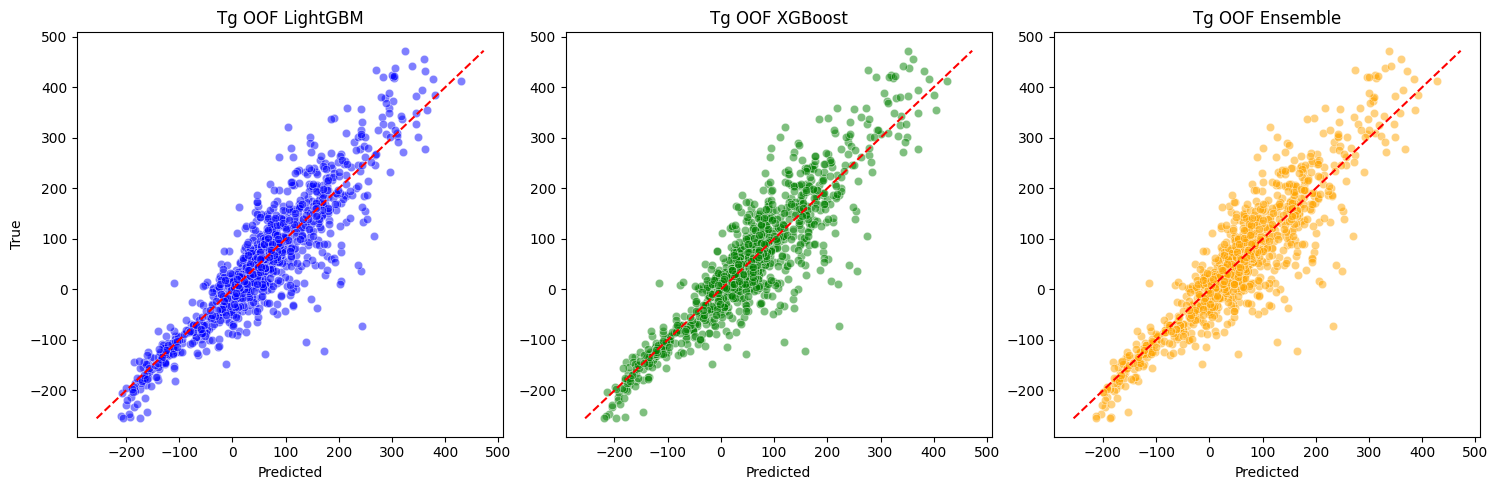

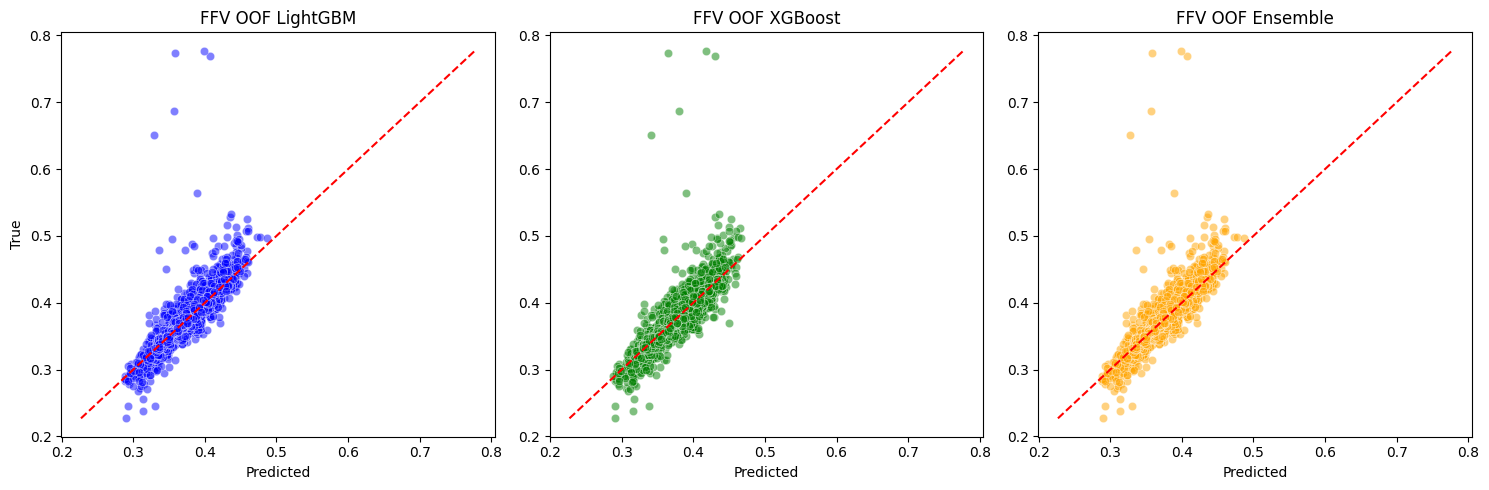

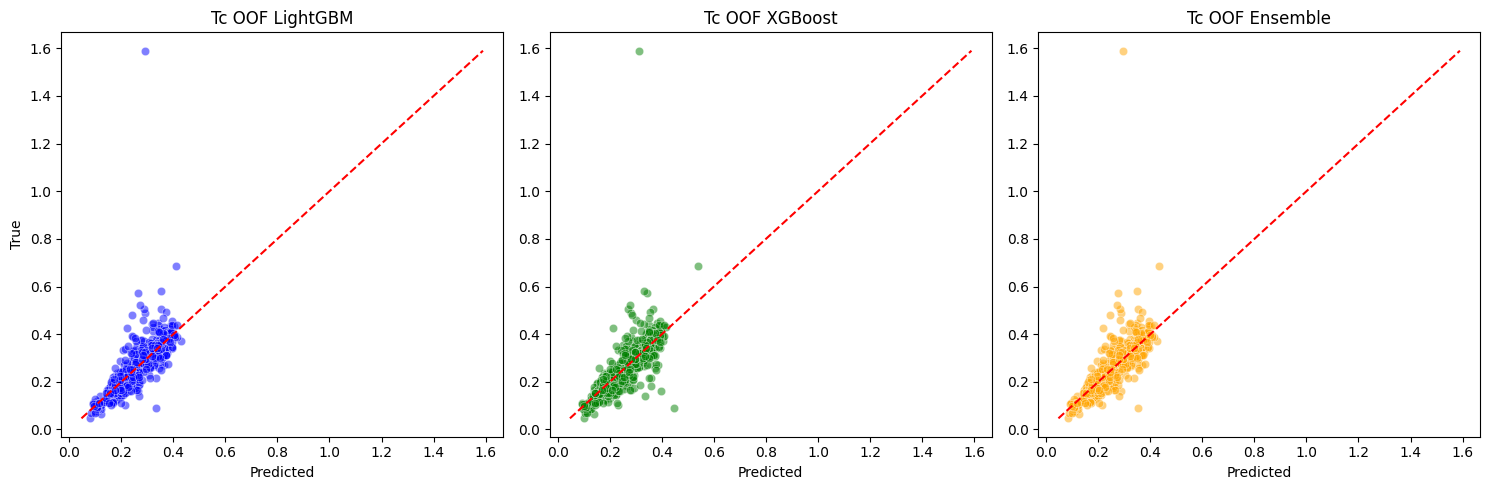

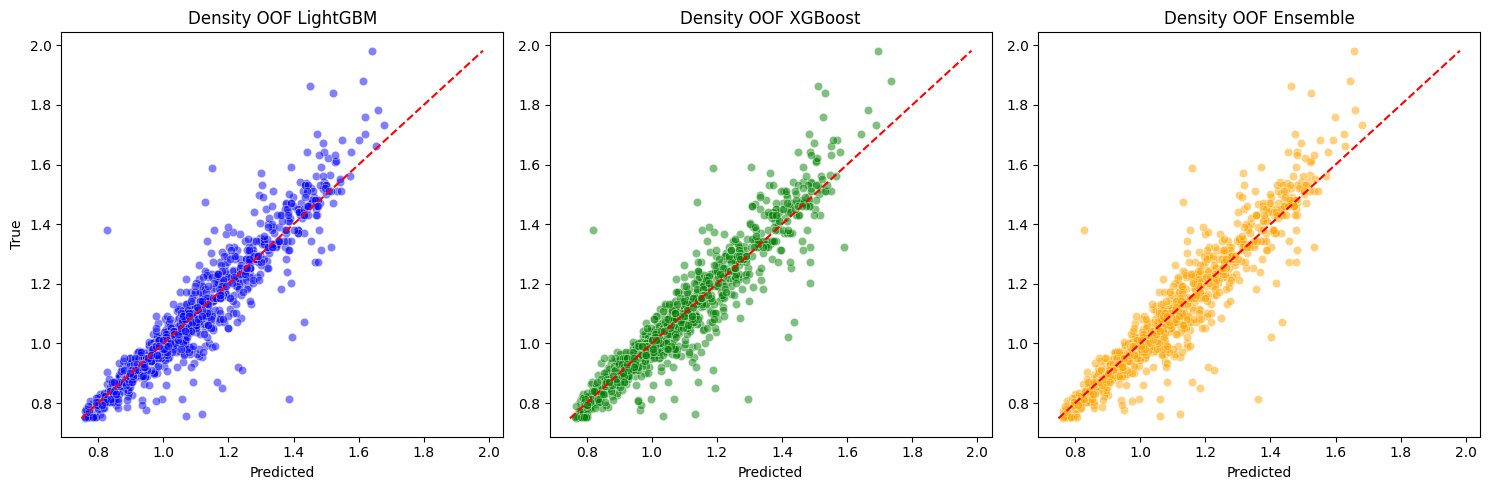

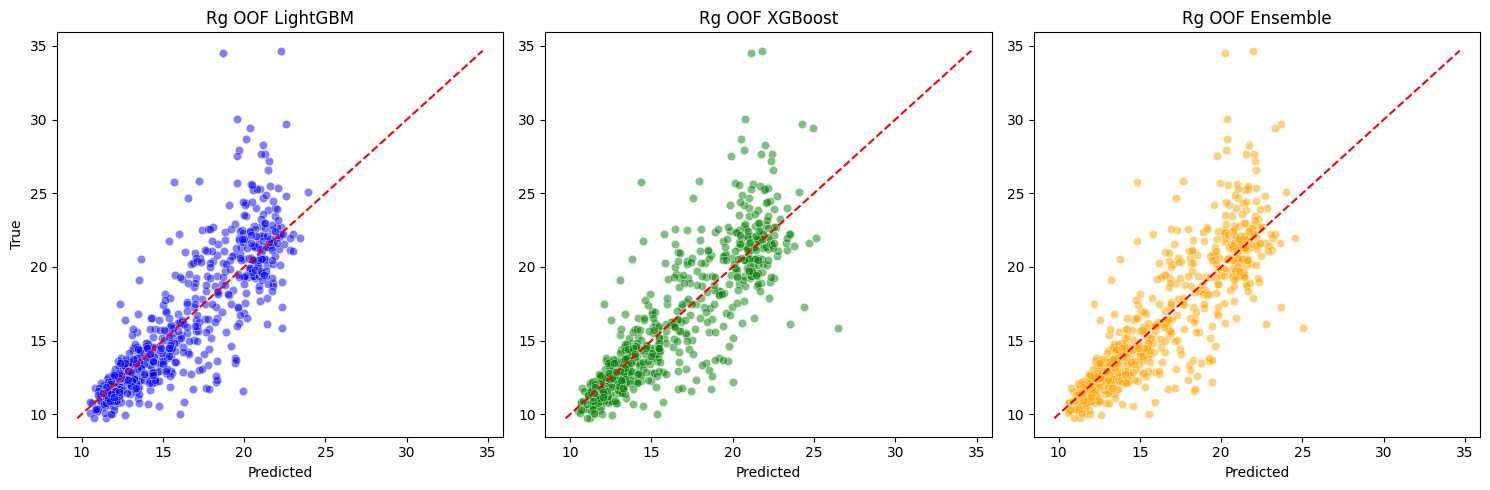

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

for t in CFG.TARGETS:
    y_true = train[train[t].notnull()][t].values
    
    # 각각 모델의 OOF 예측 (각각 딕셔너리로 저장했다고 가정)
    lgb_preds_oof = oof_lgb_dict[t]
    xgb_preds_oof = oof_xgb_dict[t]
    ens_preds_oof = oof_ens_dict[t]

    line_min = min(y_true.min(), lgb_preds_oof.min(), xgb_preds_oof.min(), ens_preds_oof.min())
    line_max = max(y_true.max(), lgb_preds_oof.max(), xgb_preds_oof.max(), ens_preds_oof.max())

    plt.figure(figsize=(15, 5))

    # LightGBM OOF
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=lgb_preds_oof, y=y_true, alpha=0.5, color='blue')
    plt.plot([line_min, line_max], [line_min, line_max], 'r--')
    plt.title(f'{t} OOF LightGBM')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # XGBoost OOF
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=xgb_preds_oof, y=y_true, alpha=0.5, color='green')
    plt.plot([line_min, line_max], [line_min, line_max], 'r--')
    plt.title(f'{t} OOF XGBoost')
    plt.xlabel('Predicted')

    # Ensemble OOF
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=ens_preds_oof, y=y_true, alpha=0.5, color='orange')
    plt.plot([line_min, line_max], [line_min, line_max], 'r--')
    plt.title(f'{t} OOF Ensemble')
    plt.xlabel('Predicted')

    plt.tight_layout()
    plt.show()

In [15]:
MINMAX_DICT =  {
        'Tg': [-148.0297376, 472.25],
        'FFV': [0.2269924, 0.77709707],
        'Tc': [0.0465, 0.524],
        'Density': [0.748691234, 1.840998909],
        'Rg': [9.7283551, 34.672905605],
    }
NULL_FOR_SUBMISSION = -9999

def scaling_error(labels, preds, property):
    error = np.abs(labels - preds)
    min_val, max_val = MINMAX_DICT[property]
    label_range = max_val - min_val
    return np.mean(error / label_range)

def get_property_weights(labels):
    property_weight = []
    for property in MINMAX_DICT.keys():
        valid_num = np.sum(labels[property] != NULL_FOR_SUBMISSION)
        property_weight.append(valid_num)
    property_weight = np.array(property_weight)
    property_weight = np.sqrt(1 / property_weight)
    return (property_weight / np.sum(property_weight)) * len(property_weight)

def wmae_score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    chemical_properties = list(MINMAX_DICT.keys())
    property_maes = []
    property_weights = get_property_weights(solution[chemical_properties])
    for property in chemical_properties:
        is_labeled = solution[property] != NULL_FOR_SUBMISSION
        property_maes.append(scaling_error(solution.loc[is_labeled, property], submission.loc[is_labeled, property], property))

    if len(property_maes) == 0:
        raise RuntimeError('No labels')
    return float(np.average(property_maes, weights=property_weights))

for target in CFG.TARGETS:
    train[f'{target}_pred'] = np.nan  # 먼저 초기화
    nonnull_idx = train[train[target].notnull()].index
    train.loc[nonnull_idx, f'{target}_pred'] = oof_results[target]

tr_solution = train[['id'] + CFG.TARGETS]
tr_submission = train[['id'] + [t + '_pred' for t in CFG.TARGETS]]
tr_submission.columns = ['id'] + CFG.TARGETS
print(f"wMAE: {round(wmae_score(tr_solution, tr_submission, row_id_column_name='id'), 5)}")

wMAE: 0.04663


**If you don't use a direct check for the presence of SMILES in the test data from external data, the LB result will be `0.47`**

In [16]:
for target in CFG.TARGETS:
    test[target] = test_results[target]
for t in CFG.TARGETS:
    for s in train[train[t].notnull()]['SMILES']:
        if s in test['SMILES'].tolist():
            test.loc[test['SMILES']==s, t] = train[train['SMILES']==s][t].values[0]

I'm rather disappointed that we are faced with the following situation, that test data contains data from publicly available sources is terrible. Also only the organizer can determine exactly where there is a license and where there is not. I'm not particularly interested in the cash prize, and I would like to make a good solution, but with only organizer's data it is difficult. I hope that the situation with the data used will become clearer.

In [17]:

test[['id'] + CFG.TARGETS].to_csv('submission.csv', index=False)